In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDFV5DE/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDFV5DE/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDFV5DE/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [9]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [10]:
sample_string = 'Ok, it seems to be working!'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string


Tokenized string is [7910, 7938, 7345, 17, 871, 5, 34, 3158, 7864]
The original string: Ok, it seems to be working!


In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))


7910 ----> O
7938 ----> k
7345 ----> , 
17 ----> it 
871 ----> seems 
5 ----> to 
34 ----> be 
3158 ----> working
7864 ----> !


In [14]:
MAX_LENGTH = 40
BUFFER_SIZE = 20000
BATCH_SIZE = 64



def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2


def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    return result_pt, result_en

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [15]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [46]:
from importlib import reload
import transformer 
import train_transformer

reload(transformer)
reload(train_transformer)

from transformer import Transformer, CustomSchedule
from train_transformer import Trainer

In [47]:
trainer = params = {'num_layers': 4,
          'd_model': 128,
          'dff': 512,
          'num_heads': 8,
          'input_vocab_size': tokenizer_pt.vocab_size + 2,
          'target_vocab_size': tokenizer_en.vocab_size + 2,
          'dropout_rate': 0.1,
          'checkpoint_path' : "./checkpoints/train",
          'MAX_LENGTH': 40,
          }


trainer = Trainer(params)

In [54]:
trainer.train_epochs(10, train_dataset)

Epoch 1 Batch 0 Loss 5.5472 Accuracy 0.1089
Epoch 1 Batch 50 Loss 5.4716 Accuracy 0.1028
Epoch 1 Batch 100 Loss 5.4023 Accuracy 0.1051
Epoch 1 Batch 150 Loss 5.3597 Accuracy 0.1075
Epoch 1 Batch 200 Loss 5.3162 Accuracy 0.1096
Epoch 1 Batch 250 Loss 5.2754 Accuracy 0.1116
Epoch 1 Batch 300 Loss 5.2362 Accuracy 0.1133
Epoch 1 Batch 350 Loss 5.2022 Accuracy 0.1148
Epoch 1 Batch 400 Loss 5.1652 Accuracy 0.1165
Epoch 1 Batch 450 Loss 5.1362 Accuracy 0.1181
Epoch 1 Batch 500 Loss 5.1035 Accuracy 0.1196
Epoch 1 Batch 550 Loss 5.0756 Accuracy 0.1211
Epoch 1 Batch 600 Loss 5.0496 Accuracy 0.1225
Epoch 1 Batch 650 Loss 5.0257 Accuracy 0.1237
Epoch 1 Batch 700 Loss 5.0018 Accuracy 0.1249
Epoch 1 Loss 5.0008 Accuracy 0.1250
Time taken for 1 epoch: 1022.0625352859497 secs

Epoch 2 Batch 0 Loss 4.4966 Accuracy 0.1567
Epoch 2 Batch 50 Loss 4.5816 Accuracy 0.1433
Epoch 2 Batch 100 Loss 4.5729 Accuracy 0.1435
Epoch 2 Batch 150 Loss 4.5628 Accuracy 0.1446
Epoch 2 Batch 200 Loss 4.5536 Accuracy 0.1453
E

NameError: ignored

Input: este é um problema que temos que resolver
Predicted translation: this is a problem that we need to solve it .


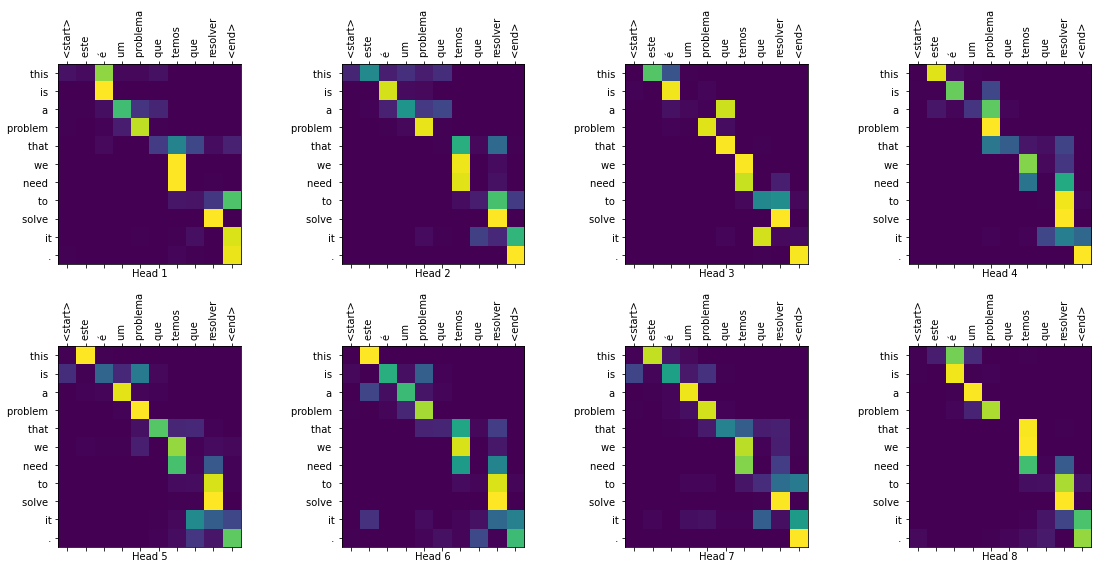

In [55]:
trainer.translate('este é um problema que temos que resolver', tokenizer_tar=tokenizer_en, tokenizer_inp=tokenizer_pt, plot='decoder_layer4_block2')